In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 24 16:35:51 2020

@author: u300737
"""
import os
import sys

import numpy as np
import pandas as pd
import xarray as xr

start_path=os.getcwd()
ac3_scripts_path=start_path+"/../scripts/"
my_git_path=start_path+"/../../"
major_work_path=my_git_path+"/../Work/GIT_Repository/"
hamp_processing_path=my_git_path+"/hamp_processing_python/"

synth_ar_path=my_git_path+"/Synthetic_Airborne_Arctic_ARs/"
retrieval_src_path=my_git_path+"/hamp_retrieval_haloac3/"
config_path=synth_ar_path+"config/"
sys.path.insert(1,config_path)
sys.path.insert(2,ac3_scripts_path)
sys.path.insert(3,synth_ar_path+"src/")
sys.path.insert(4,synth_ar_path+"plotting/")
sys.path.insert(5,hamp_processing_path)
sys.path.insert(6,hamp_processing_path+"plotting/")
sys.path.insert(7,retrieval_src_path+"src/")
sys.path.insert(8,start_path+"/../plotting/")
import data_config
###############################################################################
import flightcampaign
import moisturebudget as Budgets
###############################################################################
#Grid Data
from reanalysis import ERA5,CARRA 
from ICON import ICON_NWP as ICON
import gridonhalo as Grid_on_HALO
###############################################################################
#-----------------------------------------------------------------------------#
import warnings
warnings.filterwarnings("ignore")

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout
import Performance
performance=Performance.performance()

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
def get_relevant_retrieval_height(retrieval_coeff_heights,halo_height=5000):
    idx_height=np.argmin(abs(np.array(retrieval_coeff_heights)-halo_height))
    relevant_height=retrieval_coeff_heights[idx_height]
    return idx_height,relevant_height

def open_height_relevant_retrieval(retrieval_coeff_heights,var_to_retrieve,act_halo_height,
                                   coeff_path="C:\\Users\\u300737\\Desktop\\Desktop_alter_Rechner\\"+\
                                   "PhD_UHH_WIMI\\Work\\GIT_Repository\\hamp_processing_py\\hamp_processing_python\\"+\
                                   "Flight_Data\\HALO_AC3\\retrieval\\"):
    height=act_halo_height.copy()
    idx_height,relevant_height=get_relevant_retrieval_height(retrieval_coeff_heights,halo_height=height)
    m_est_height=pd.read_csv(coeff_path+var_to_retrieve+"_Retrieval_coeffs_several_dates_"+str(relevant_height)+".csv",
                            index_col="Unnamed: 0")
    return m_est_height

## Plotting routines

In [3]:
import matplotlib
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import gridspec
            
def plot_q_retrieval(flight,ar_of_day,var_to_retrieve,var_retrieved):
    correct_sector=True
    if flight[0]=="RF06":
        if ar_of_day=="AR_entire_1":
            print("This AR sector suffers HAMP data gaps")
            correct_sector=False
        elif ar_of_day=="AR_entire_2":
            print("This sector overpasses sea-ice where the retrieval is not yet performing correctly.")
            correct_sector=False
    if correct_sector:
        set_font=18
        matplotlib.rcParams.update({"font.size":set_font})
        hours=mdates.MinuteLocator(byminute=[0,30],interval=1)
        h_fmt=mdates.DateFormatter("%H:%M")
        humidity_colormap="terrain_r"
        temperature_colormap="RdYlBu_r"
        if var_to_retrieve=="q" or var_to_retrieve=="log_q":
            cmap_to_use=humidity_colormap
            val_max=6
            val_min=0
            val_values=var_retrieved.T*1000
            unit_name="Specific humidity (g/kg)"
        elif var_to_retrieve=="t":
            cmap_to_use=temperature_colormap
            val_max=275
            val_min=210
            val_values=var_retrieved.T
            unit_name="Temperature (K)"
            levels=np.linspace(val_min,val_max,61)
        # Real figure
        fig=plt.figure(figsize=(12,9))
        ax1=fig.add_subplot(111)

        C1=ax1.pcolormesh(var_retrieved.index,var_retrieved.columns/1000,val_values,
                  vmin=val_min,vmax=val_max,cmap=cmap_to_use)
        #for sonde_release in sonde_data["IWV"].index:
        #    ax1.axvline(x=sonde_release,color="gray",ls="--",lw=3)

        cb=plt.colorbar(C1,extend="max")
        cb.set_label(unit_name)
        ax1.set_ylabel("Height (km)")
        ax1.set_xlabel("Time")
        ax1.set_ylim([0,15])
        ax1.xaxis.set_major_locator(hours)
        ax1.xaxis.set_major_formatter(h_fmt)
        ax1.set_title("HAMP-TBs Retrieval "+var_to_retrieve)
        fig.savefig("HAMP_Retrieval_Tbs_"+var_to_retrieve+".png",dpi=300,bbox_inches="tight")
        print("Figure saved as:","HAMP_Retrieval_Tbs_"+var_to_retrieve+".png")
        plt.show()

def plot_vertical_sonde_profiles(Moisture_CONV,plot_path):
    matplotlib.rcParams.update({"font.size":16})
    sonde_fig=plt.figure(figsize=(12,12))
    ax1=sonde_fig.add_subplot(131)
    ax2=sonde_fig.add_subplot(132)
    ax3=sonde_fig.add_subplot(133,sharey=ax2)
    ax1.plot(Moisture_CONV.sector_sonde_values[sector_to_plot]["q"]*1000,
         Moisture_CONV.sector_sonde_values[sector_to_plot]["q"].index/1000,
                                  color="lightblue",lw=1)
    mean_sector_q=Moisture_CONV.sector_sonde_values[sector_to_plot]["q"].mean(axis=1)
    ax1.plot(mean_sector_q*1000,mean_sector_q.index/1000,color="darkblue",lw=2)

    ax1.set_ylim([0,12])
    ax2.set_ylim([0,12])
    ax3.set_ylim([0,12])

    ax1.set_xlim([0,6])
    #wind speed
    ax2.plot(Moisture_CONV.sector_sonde_values[sector_to_plot]["wind"],
         Moisture_CONV.sector_sonde_values[sector_to_plot]["q"].index/1000,
         color="thistle",lw=1)
    mean_sector_wind=Moisture_CONV.sector_sonde_values[sector_to_plot]["wind"].mean(axis=1)
    ax2.plot(mean_sector_wind,mean_sector_wind.index/1000,color="purple",lw=2)
    ax2.set_xlim([0,50])
    #transport
    mean_sector_transport=Moisture_CONV.sector_sonde_values[sector_to_plot]["transport"].mean(axis=1)
    ax3.plot(Moisture_CONV.sector_sonde_values[sector_to_plot]["transport"],
         Moisture_CONV.sector_sonde_values[sector_to_plot]["q"].index/1000,
                                  color="darkseagreen")
    ax3.plot(mean_sector_transport,
         Moisture_CONV.sector_sonde_values[sector_to_plot]["q"].index/1000,
                                  lw=2,color="darkgreen")
    ax3.set_xlim([0,0.15])
    ax2.set_yticklabels([])
    ax3.set_yticklabels([])
    ax1.set_xlabel("Specific Humidity (g/kg)")
    ax2.set_xlabel("Wind speed (m/s)")
    ax3.set_xlabel("Moisture Transport (g/kgms)")

    ax1.yaxis.set_tick_params(width=2,length=6)
    ax1.xaxis.set_tick_params(width=2,length=6)
    ax2.yaxis.set_tick_params(width=2,length=6)
    ax2.xaxis.set_tick_params(width=2,length=6)
    ax3.yaxis.set_tick_params(width=2,length=6)
    ax3.xaxis.set_tick_params(width=2,length=6)
    for axis in ['bottom','left']:
        ax1.spines[axis].set_linewidth(3)
        ax2.spines[axis].set_linewidth(3)
        ax3.spines[axis].set_linewidth(3)
    ax1.set_ylabel("Height (km)")
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    plt.suptitle("Sonde Moisture transport convergence "+flight[0]+" "+ar_of_day+" "+sector_to_plot)
    
    sns.despine(offset=10,ax=ax1)
    sns.despine(offset=10,ax=ax2)
    sns.despine(offset=10,ax=ax3)
    fig_name=flight[0]+"_"+ar_of_day+"_"+sector_to_plot+"_Sondes.png"
    sonde_fig.savefig(plot_path+fig_name,dpi=300,bbox_inches="tight")
    print("Figure saved as:",plot_path+fig_name)
#%% Plotting
def plot_haloac3_atmospheric_moist_trans_divergence(Moisture_CONV,ICON_Moisture_CONV,
                                                    Retr_Moisture_CONV,sector_to_plot,
                                                   z_height_icon,z_height_retrieval,
                                                   plot_sondes=True,
                                                   do_plot_icon=True,
                                                   scalar_based_div=True):
    
    import matplotlib
    #if hasattr(Retr_Moisture_CONV, "div_scalar_mass"):plot_retrieval=True
    #else: 
    plot_retrieval=False
    
    import seaborn as sns
    matplotlib.rcParams.update({"font.size":20})
    divergence_plot=plt.figure(figsize=(16,9))
    ax1=divergence_plot.add_subplot(121)
    ax2=divergence_plot.add_subplot(122)
    # Mass divergence
    if plot_sondes:
        # Either sonde scalar based or vector based
        if scalar_based_div:
            if isinstance(Moisture_CONV.div_scalar_mass[sector_to_plot],pd.Series):
                ax1.plot(Moisture_CONV.div_scalar_mass[sector_to_plot].values,
                 Moisture_CONV.div_scalar_mass[sector_to_plot].index.values/1000,
                 color="darkgreen",lw=3,label="Dropsondes")
            else:
                ax1.plot(Moisture_CONV.div_scalar_mass[sector_to_plot]["val"].values,
                 Moisture_CONV.div_scalar_mass[sector_to_plot].index.values/1000,
                 color="darkgreen",lw=3,label="Dropsondes")
                ax1.fill_betweenx(Moisture_CONV.div_scalar_mass[sector_to_plot].index.values/1000,
                    x1=Moisture_CONV.div_scalar_mass[sector_to_plot]["val"].values-\
                    Moisture_CONV.div_scalar_mass[sector_to_plot]["unc"].values,
                    x2=Moisture_CONV.div_scalar_mass[sector_to_plot]["val"].values+\
                    Moisture_CONV.div_scalar_mass[sector_to_plot]["unc"].values,
                                color="lightgreen",alpha=0.4)
        else:
            if isinstance(Moisture_CONV.div_vector_mass[sector_to_plot],pd.Series):
                ax1.plot(Moisture_CONV.div_vector_mass[sector_to_plot].values,
                 Moisture_CONV.div_vector_mass[sector_to_plot].index.values/1000,
                 color="darkgreen",lw=3,label="Dropsondes")
            else:
                ax1.plot(Moisture_CONV.div_vector_mass[sector_to_plot]["val"].values,
                 Moisture_CONV.div_vector_mass[sector_to_plot].index.values/1000,
                 color="darkgreen",lw=3,label="Dropsondes")
                ax1.fill_betweenx(Moisture_CONV.div_vector_mass[sector_to_plot].index.values/1000,
                    x1=Moisture_CONV.div_vector_mass[sector_to_plot]["val"].values-\
                    Moisture_CONV.div_vector_mass[sector_to_plot]["unc"].values,
                    x2=Moisture_CONV.div_vector_mass[sector_to_plot]["val"].values+\
                    Moisture_CONV.div_vector_mass[sector_to_plot]["unc"].values,
                                color="lightgreen",alpha=0.4)
    if do_plot_icon:        
        ax1.plot(ICON_Moisture_CONV.div_scalar_mass[sector_to_plot].values,
             z_height_icon.values[1:]/1000,color="black",marker="s",
         markersize=2,lw=4,ls="--",label="ICON-2km")
    if plot_retrieval:
        ax1.plot(Retr_Moisture_CONV.div_scalar_mass[sector_to_plot].values,
             z_height_retrieval.values/1000,color="teal",lw=3,ls="-.",label="HAMP")

    ax1.set_xlim([-2.5e-4,2.5e-4])
    ax1.set_xticks([-2.5e-4,-1e-4,0,1e-4,2.5e-4])
    ax1.set_xticklabels(["-2.5e-4","-1e-4","0","1e-4","2.5e-4"])
    ax1.text(x=0.6,y=0.66,s="Vertical Integral\nBudget Contribution:",transform=ax1.transAxes,color="k")
    if plot_sondes:
        ax1.text(x=0.7,y=0.6,s=str(np.round(-1*Moisture_CONV.integrated_divergence[sector_to_plot]["mass_div"],2))+\
         " $\mathrm{mmh}^{-1}$",transform=ax1.transAxes,color="darkgreen")
    ax1.text(x=0.7,y=0.55,s=str(np.round(-1*ICON_Moisture_CONV.integrated_divergence[sector_to_plot]["mass_div"],2))+\
         " $\mathrm{mmh}^{-1}$",transform=ax1.transAxes,color="k")
    if plot_retrieval:
        ax1.text(x=0.7,y=0.5,s=str(np.round(-1*Retr_Moisture_CONV.integrated_divergence[sector_to_plot]["mass_div"],2))+\
         " $\mathrm{mmh}^{-1}$",transform=ax1.transAxes,color="teal")
    ax1.set_xlabel("Mass Divergence ($\mathrm{gkg}^{-1}\mathrm{s}^{-1}$)")
    ax1.set_ylabel("Height (km)")
    ax1.axvline(x=0,ls="--",lw=3,color="grey")
    ax1.set_ylim([0,10])
    for axis in ['bottom','left']:
        ax1.spines[axis].set_linewidth(3)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.yaxis.set_tick_params(width=2,length=6)
    ax1.xaxis.set_tick_params(width=2,length=6)
    ax1.legend(loc="upper right",fontsize=22,bbox_to_anchor=[1.15,1.0])
    
    # moisture advection
    if plot_sondes:
        if scalar_based_div:
            if isinstance(Moisture_CONV.adv_q_calc[sector_to_plot],pd.Series):
                ax2.plot(Moisture_CONV.adv_q_calc[sector_to_plot].values,
                 Moisture_CONV.adv_q_calc[sector_to_plot].index.values/1000,
                 color="darkgreen",lw=3)
            else:
                ax2.plot(Moisture_CONV.adv_q_calc[sector_to_plot]["val"].values,
                 Moisture_CONV.adv_q_calc[sector_to_plot].index.values/1000,
                 color="darkgreen",lw=3)
                ax2.fill_betweenx(y=Moisture_CONV.adv_q_calc[sector_to_plot].index.values/1000,
                 x1=Moisture_CONV.adv_q_calc[sector_to_plot]["val"].values-\
                        Moisture_CONV.adv_q_calc[sector_to_plot]["unc"].values,
                 x2=Moisture_CONV.adv_q_calc[sector_to_plot]["val"].values+\
                        Moisture_CONV.adv_q_calc[sector_to_plot]["unc"].values,
                 color="lightgreen",alpha=0.4)
        else:
            # vector based results
            if isinstance(Moisture_CONV.adv_q_vector[sector_to_plot],pd.Series):
                ax2.plot(Moisture_CONV.adv_q_vector[sector_to_plot].values,
                 Moisture_CONV.adv_q_vector[sector_to_plot].index.values/1000,
                 color="darkgreen",lw=3)
            else:
                ax2.plot(Moisture_CONV.adv_q_vector[sector_to_plot]["val"].values,
                 Moisture_CONV.adv_q_vector[sector_to_plot].index.values/1000,
                 color="darkgreen",lw=3)
                ax2.fill_betweenx(y=Moisture_CONV.adv_q_vector[sector_to_plot].index.values/1000,
                 x1=Moisture_CONV.adv_q_vector[sector_to_plot]["val"].values-\
                        Moisture_CONV.adv_q_vector[sector_to_plot]["unc"].values,
                 x2=Moisture_CONV.adv_q_vector[sector_to_plot]["val"].values+\
                        Moisture_CONV.adv_q_vector[sector_to_plot]["unc"].values,
                 color="lightgreen",alpha=0.4)
            
    ax2.plot(ICON_Moisture_CONV.adv_q_calc[sector_to_plot].values,
         z_height_icon.values[1::]/1000,
         color="k",markersize=2,ls="--",lw=4)
    if plot_retrieval:
        ax2.plot(Retr_Moisture_CONV.adv_q_calc[sector_to_plot].values,
         z_height_retrieval.values/1000,
         color="teal",markersize=2,ls="-.",lw=3)
        
    ax2.set_ylim([0,10])
    ax2.set_xlim([-2.5e-4,2.5e-4])
    ax2.set_xticks([-2.5e-4,-1e-4,0,1e-4,2.5e-4])
    ax2.set_xticklabels(["-2.5e-4","-1e-4","0","1e-4","2.5e-4"])
    ax2.axvline(x=0,ls="--",lw=3,color="grey")
    ax2.set_xlabel("Moisture Advection ($\mathrm{gkg}^{-1}\mathrm{s}^{-1}$)")
    for axis in ['bottom','left']:
        ax2.spines[axis].set_linewidth(3)
    ax2.set_yticklabels("")
    if plot_sondes:
        ax2.text(x=0.7,y=0.6,s=str(np.round(-1*Moisture_CONV.integrated_divergence[sector_to_plot]["q_ADV"],2))+\
         " $\mathrm{mmh}^{-1}$",transform=ax2.transAxes,color="darkgreen")
    ax2.text(x=0.7,y=0.55,s=str(np.round(-1*ICON_Moisture_CONV.integrated_divergence[sector_to_plot]["q_ADV"],2))+\
         " $\mathrm{mmh}^{-1}$",transform=ax2.transAxes,color="k")
    
    if plot_retrieval:
        ax2.text(x=0.7,y=0.5,s=str(np.round(-1*Retr_Moisture_CONV.integrated_divergence[sector_to_plot]["q_ADV"],2))+\
         " $\mathrm{mmh}^{-1}$",transform=ax2.transAxes,color="teal")
    
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.yaxis.set_tick_params(width=2,length=6)
    ax2.xaxis.set_tick_params(width=2,length=6)
    plt.suptitle("Sonde Moisture transport divergence "+flight[0]+" "+ar_of_day+" "+sector_to_plot)
    sns.despine(offset=10)
    plt.subplots_adjust(wspace=0.3)
    fig_name=flight[0]+"_"+ar_of_day+"_"+sector_to_plot+"_sonde_moist_transp_divergence.png"
    divergence_plot.savefig(plot_path+fig_name,dpi=300,bbox_inches="tight")
    print("Figure saved as:",plot_path+fig_name)
    
def plot_internal_iwv_tendency(sonde_times_series,Dropsondes,IWV_retrieved,sector_to_plot="warm"):
    # ---- Add this one : internal_sondes_dict["cold"]
    matplotlib.rcParams.update({"font.size":28})
    # Internal sondes iwv
    time_list=[str(time) for time in sonde_times_series.index]
    Dropsondes["new_alt"]=Dropsondes["alt"].copy()
    new_key_list=[]
    for key in [*Dropsondes["alt"].keys()]:
        new_key=str(pd.Timestamp(key))
        Dropsondes["alt"][new_key] = Dropsondes["alt"].pop(key)
    iwv_sonde=Dropsondes["IWV"].iloc[internal_sondes_dict[sector_to_plot]]
    minutes_to_divide=iwv_sonde.index.to_series().diff().astype('timedelta64[m]')[-1]
    iwv_sonde_diff=iwv_sonde.diff()[-1]/minutes_to_divide*60

    #hamp_gradients using 1min mean
    hamp_iwv_internal_mean=pd.Series(data=np.nan,index=iwv_sonde.index)
    for t,sonde_time in enumerate(iwv_sonde.index):
        if flight[0]=="RF06" and ar_of_day=="AR_entire_1" and t==0:
            sonde_period_start= pd.Timestamp("2022-03-16 12:01")-pd.Timedelta("30s")
            sonde_period_end  = pd.Timestamp("2022-03-16 12:01")+pd.Timedelta("30s")
        else:    
            sonde_period_start= pd.Timestamp(sonde_time)-pd.Timedelta("30s")
            sonde_period_end  = pd.Timestamp(sonde_time)+pd.Timedelta("30s")
    
        mean_iwv_sonde_values=IWV_retrieved.loc[str(sonde_period_start):\
                                                             str(sonde_period_end)].mean()
        hamp_iwv_internal_mean.loc[sonde_time]=mean_iwv_sonde_values

    hamp_iwv_diff=hamp_iwv_internal_mean.diff()/minutes_to_divide*60
    icon_iwv_diff=pd.Series(data=np.nan, index=iwv_sonde.index)

    iwv_sonde_fig=plt.figure(figsize=(8,14))
    ax1=iwv_sonde_fig.add_subplot(111)
    matplotlib.rcParams['axes.linewidth'] = 3
    ax1.patch.set_facecolor('lightgrey')
    ax1.patch.set_alpha(0.5)
    time_key_list=[*Dropsondes["q"].keys()]
    if sector_to_plot=="warm":
        colors=["darkorange","moccasin"]
    else:
        colors=["darkviolet","plum"]

    for c,sonde_time in enumerate(internal_sondes_dict[sector_to_plot]):
        if sector_to_plot=="warm":
            relevant_timestamp=time_key_list[sonde_time]
            ax1.scatter(Dropsondes["q"][relevant_timestamp]*1000,Dropsondes["alt"][str(relevant_timestamp)]/1000,
            color="k",s=140)
            ax1.scatter(Dropsondes["q"][relevant_timestamp]*1000,Dropsondes["alt"][str(relevant_timestamp)]/1000,
                label="Sonde "+str(relevant_timestamp),color=colors[c],s=80)
            iwv_sonde=Dropsondes["q"][relevant_timestamp]
        else:
            relevant_timestamp=pd.Timestamp(sonde_time)
        
        icon_q_sondes={}
        icon_z_sondes={}
        if relevant_timestamp>halo_df.index[-1]:
            icon_q_sondes["Sonde"+str(c)]=snd_halo_icon_hmc["q"].loc[relevant_timestamp-pd.Timedelta("1min"):\
                                                         relevant_timestamp+pd.Timedelta("1min")].mean(axis=0)
            icon_z_sondes["Sonde"+str(c)]=snd_halo_icon_hmc["Z_Height"].loc[relevant_timestamp-pd.Timedelta("1min"):\
                                                                relevant_timestamp+pd.Timedelta("1min")].mean(axis=0)
            icon_iwv_diff.iloc[c]=snd_halo_icon_hmp["Interp_IWV"].loc[relevant_timestamp-pd.Timedelta("1min"):\
                                            relevant_timestamp+pd.Timedelta("1min")].mean(axis=0)
        else:
            icon_q_sondes["Sonde"+str(c)]=halo_icon_hmc["q"].loc[relevant_timestamp-pd.Timedelta("1min"):\
                                                         relevant_timestamp+pd.Timedelta("1min")].mean(axis=0)
            icon_z_sondes["Sonde"+str(c)]=halo_icon_hmc["Z_Height"].loc[relevant_timestamp-pd.Timedelta("1min"):\
                                                                relevant_timestamp+pd.Timedelta("1min")].mean(axis=0)
            icon_iwv_diff.iloc[c]=halo_icon_hmp["Interp_IWV"].loc[relevant_timestamp-pd.Timedelta("1min"):\
                                            relevant_timestamp+pd.Timedelta("1min")].mean(axis=0)
        ax1.scatter(icon_q_sondes["Sonde"+str(c)]*1000,
                icon_z_sondes["Sonde"+str(c)]/1000,
                marker="v", s=150, color=colors[c],edgecolor="k",
                label="ICON "+str(relevant_timestamp))
    if sector_to_plot=="warm":
        iwv_icon_diff_h=icon_iwv_diff.diff()[-1]/minutes_to_divide*60
    else:
        iwv_icon_diff_h=icon_iwv_diff.diff()[-1]/minutes_to_divide*60
    ax1.set_xlabel("Specific humidity (${\mathrm{gkg}}^{-1}$)")
    ax1.set_ylabel("Height (km)")
    ax1.set_xlim([0,5])
    ax1.set_ylim([0,12])
    if sector_to_plot=="warm":
        ax1.text(1.4,7,"$\dfrac{\delta {IWV}_{\mathrm{Sonde}}}{\delta t}=$"+str(round(iwv_sonde_diff,2))+" $\mathrm{mmh}^{-1}$",
         fontsize=25)
        ax1.text(1.4,6,"$\dfrac{\delta {IWV}_{\mathrm{ICON}}}{\delta t}=$"+str(round(iwv_icon_diff_h,2))+" $\mathrm{mmh}^{-1}$",
         fontsize=25)
        ax1.text(1.4,5,"$\dfrac{\delta {IWV}_{\mathrm{HAMP}}}{\delta t}=$"+str(round(hamp_iwv_diff[-1],2))+" $\mathrm{mmh}^{-1}$",
        fontsize=25)
    ax1.xaxis.set_tick_params(width=3,length=10)
    ax1.yaxis.set_tick_params(width=3,length=10)
    ax1.legend(fontsize=24)
    sns.despine(offset=10)
    fig_name=flight[0]+"_"+ar_of_day+"_"+sector_to_plot+"_sonde_iwv_tendency.png"
    iwv_sonde_fig.savefig(plot_path+fig_name,dpi=300,bbox_inches="tight")
    print("Figure saved as:",plot_path+fig_name)

## Switches and Definitions

In [5]:
campaign="HALO_AC3"
ar_of_day="AR_entire_2"
calibrated_hamp=True
flight=["RF06"]
flight_dates={"RF05":"20220315",
              "RF06":"20220316"}
sector_to_plot="warm"

scalar_based_div=False
take_arbitary=False
do_plotting=True
plot_path=start_path+"/../plots/"
if not os.path.exists(plot_path):
    os.makedirs(plot_path)


In [6]:
from simplified_flight_leg_handling import simplified_run_grid_main
#-----------------------------------------------------------------------------#        
"""
###############################################################################
    Main Script for running interpolation of griddata on flight path
###############################################################################
"""    
with HiddenPrints():
    halo_era5,halo_df,cmpgn_cls,ERA5_on_HALO,radar,Dropsondes=\
        simplified_run_grid_main(flight=flight,config_file_path=major_work_path,ar_of_day=ar_of_day)

In [7]:
if not "Lat" in [*Dropsondes.keys()]:
    sondes_lon=[[*Dropsondes["reference_lon"].values()][sonde].data[0] \
                    for sonde in range(Dropsondes["IWV"].shape[0])]
                    
    sondes_lat=[[*Dropsondes["reference_lat"].values()][sonde].data[0]\
                    for sonde in range(Dropsondes["IWV"].shape[0])]
    Dropsondes["Lat"]=pd.Series(data=np.array(sondes_lat),
                                                index=Dropsondes["IWV"].index)
    Dropsondes["Lon"]=pd.Series(data=np.array(sondes_lon),
                                                index=Dropsondes["IWV"].index)
sonde_times_series=pd.Series(index=Dropsondes["IWV"].index.values,data=range(Dropsondes["IWV"].shape[0]))

In [8]:
import reanalysis as Reanalysis
file_name="total_columns_"+cmpgn_cls.years[flight[0]]+"_"+\
                    cmpgn_cls.flight_month[flight[0]]+"_"+\
                    cmpgn_cls.flight_day[flight[0]]+".nc"    
        
era5=Reanalysis.ERA5(for_flight_campaign=True,campaign="HALO_AC3",
                  research_flights=flight,
                  era_path=cmpgn_cls.campaign_path+"/data/ERA-5/")
        
ds,era_path=era5.load_era5_data(file_name)
        
#IVT Processing
ds["IVT_v"]=ds["p72.162"]
ds["IVT_u"]=ds["p71.162"]
ds["IVT"]=np.sqrt(ds["IVT_u"]**2+ds["IVT_v"]**2)
ds["IVT_conv"]=ds["p84.162"]*3600 # units in seconds        

In [9]:
if flight[0]=="RF05":
    if ar_of_day=="AR_entire_1":
            inflow_times=["2022-03-15 10:11","2022-03-15 11:13"]
            internal_times=["2022-03-15 11:18","2022-03-15 12:14"]
            outflow_times=["2022-03-15 12:20","2022-03-15 13:15"]
    elif ar_of_day=="AR_entire_2":
            inflow_times=["2022-03-15 14:30","2022-03-15 15:25"]
            internal_times=["2022-03-15 13:20","2022-03-15 14:25"]
            outflow_times=["2022-03-15 12:20","2022-03-15 13:15"]
if flight[0]=="RF06":
    if ar_of_day=="AR_entire_1":
            inflow_times=["2022-03-16 10:45","2022-03-16 11:21"]
            internal_times=["2022-03-16 11:25","2022-03-16 12:10"]
            outflow_times=["2022-03-16 12:15","2022-03-16 12:50"]
    elif ar_of_day=="AR_entire_2":
            inflow_times=["2022-03-16 12:12","2022-03-16 12:55"]
            internal_times=["2022-03-16 12:58","2022-03-16 13:40"]
            outflow_times=["2022-03-16 13:45","2022-03-16 14:18"]

new_halo_dict={flight[0]:{"inflow":halo_df.loc[inflow_times[0]:inflow_times[-1]],
                          "internal":halo_df.loc[internal_times[0]:internal_times[-1]],
                          "outflow":halo_df.loc[outflow_times[0]:outflow_times[-1]]}}

from atmospheric_rivers import Atmospheric_Rivers
AR_inflow,AR_outflow=Atmospheric_Rivers.locate_AR_cross_section_sectors(
                                    new_halo_dict,ERA5_on_HALO.halo_era5,
                                    flight[0])

relevant_sondes_dict={}
internal_sondes_dict={}
if take_arbitary:
    for sector in ["warm_sector","core","cold_sector"]:
        print("Analyse frontal sector ",sector)
        #add_sonde=1
        #if sector=="core":
        #    add_sonde=1
        AR_sector_in                       = AR_inflow["AR_inflow_"+sector]
        AR_sector_out                      = AR_outflow["AR_outflow_"+sector]
        
        relevant_sondes_dict[sector]       = {}
        relevant_sondes_dict[sector]["in"] = sonde_times_series.loc[AR_sector_in.index[0]:AR_sector_in.index[-1]]
        relevant_sondes_dict[sector]["out"]= sonde_times_series.loc[AR_sector_out.index[0]:AR_sector_out.index[-1]]
        
else:
    if flight[0]=="RF05":
        if ar_of_day=="AR_entire_1":
            relevant_warm_sector_sondes=[0,1,2,3,9,10,11,12]
            relevant_cold_sector_sondes=[4,5,6]
            relevant_warm_internal_sondes=[7,13]
            relevant_sondes_dict["warm_sector"]        = {}
            relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[0:4]]
            relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[4::]]
            relevant_sondes_dict["cold_sector"]        = {}
            relevant_sondes_dict["cold_sector"]["in"]  = sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
            #relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes[3::]]
            synthetic_sonde_times_series=pd.Series(data=["7synth","8synth","9synth"],
                                     index=pd.DatetimeIndex(["2022-03-15 12:55","2022-03-15 13:05","2022-03-15 13:15"]))
            relevant_sondes_dict["cold_sector"]["out"] = synthetic_sonde_times_series
            internal_sondes_dict["warm"]               = sonde_times_series.iloc[relevant_warm_internal_sondes]
            internal_sondes_dict["cold"]               = ["2022-03-15 11:30:00","2022-03-15 13:35"]   
        elif ar_of_day=="AR_entire_2":
            relevant_warm_sector_sondes=[9,10,11,12,15,16,17,18]
            relevant_cold_sector_sondes=[19,20,21]
            relevant_warm_internal_sondes=[13,22]
            relevant_sondes_dict["warm_sector"]        = {}
            relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[4::]]
            relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[0:4]]
            relevant_sondes_dict["cold_sector"]        = {}
            relevant_sondes_dict["cold_sector"]["in"]  = pd.Series()#sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
            relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes]
            internal_sondes_dict["warm"]               = sonde_times_series.iloc[relevant_warm_internal_sondes]
    elif flight[0]=="RF06":
        if ar_of_day=="AR_entire_1":
            relevant_warm_sector_sondes=[0,1,2,8,9,10]
            relevant_cold_sector_sondes=[3,4,5,11,12]
            relevant_warm_internal_sondes=[7,22]
            relevant_sondes_dict["warm_sector"]        = {}
            relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[0:3]]
            relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[3:]]
            relevant_sondes_dict["cold_sector"]        = {}
            relevant_sondes_dict["cold_sector"]["in"]  = sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
            relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes[3:]]
            internal_sondes_dict["warm"]               = sonde_times_series.iloc[relevant_warm_internal_sondes]
        elif ar_of_day=="AR_entire_2":
            relevant_warm_sector_sondes=[8,9,16,17]
            relevant_cold_sector_sondes=[10,11,12,18,19]
            relevant_warm_internal_sondes=[21,22]
            relevant_sondes_dict["warm_sector"]        = {}
            relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[0:2]]
            relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[2::]]
            relevant_sondes_dict["cold_sector"]        = {}
            relevant_sondes_dict["cold_sector"]["in"]  = sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
            relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes[3::]]
            internal_sondes_dict["warm"]               = sonde_times_series.iloc[relevant_warm_internal_sondes]
#relevant_sondes_dict["warm_sector"]["in"]

### ICON

In [10]:
icon_major_path=cmpgn_cls.campaign_path+"/data/ICON_LEM_2KM/"
hydrometeor_icon_path=cmpgn_cls.campaign_path+"/data/ICON_LEM_2KM/"
icon_resolution=2000 # units m
icon_var_list=ICON.lookup_ICON_AR_period_data(campaign,flight,ar_of_day,
                                                 icon_resolution,
                                                 hydrometeor_icon_path,
                                                 synthetic=False)
halo_df=halo_df.rename(columns={"lat":"latitude",
                                "lon":"longitude"})

ICON_on_HALO=Grid_on_HALO.ICON_on_HALO(
                            cmpgn_cls,icon_var_list,halo_df,flight,flight_dates[flight[0]],
                            interpolated_hmp_file=flight[0]+"_"+ar_of_day+"_"+"interpolated_HMP.csv",
                            interpolated_hmc_file=None,ar_of_day=ar_of_day,
                            synthetic_icon=False,
                            synthetic_flight=False)
if campaign=="HALO_AC3":
    hydrometeor_icon_path=hydrometeor_icon_path+flight[0]+"/"
    ICON_on_HALO.update_ICON_hydrometeor_data_path(hydrometeor_icon_path)
    
# ICON Values on HALO
halo_icon_hmc=ICON_on_HALO.load_hwc(with_hydrometeors=False)
halo_icon_hmp=ICON_on_HALO.load_interpolated_hmp()        
#Second ar of day
snd_ICON_on_HALO=Grid_on_HALO.ICON_on_HALO(cmpgn_cls,icon_var_list,halo_df,flight,flight_dates[flight[0]],
                interpolated_hmp_file=flight[0]+"_"+"AR_entire_2"+"_"+"interpolated_HMP.csv",
                interpolated_hmc_file=None,ar_of_day="AR_entire_2",
                synthetic_icon=False,synthetic_flight=False)
if campaign=="HALO_AC3":
    snd_ICON_on_HALO.update_ICON_hydrometeor_data_path(hydrometeor_icon_path)
    # ICON Values on HALO
    snd_halo_icon_hmc=snd_ICON_on_HALO.load_hwc(with_hydrometeors=False)
    snd_halo_icon_hmp=snd_ICON_on_HALO.load_interpolated_hmp()
#snd_halo_icon_hmp

File of interest: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3/data/ICON_LEM_2KM/RF06/RF06_AR_entire_2_V_Wind_interpolated_profile.csv
Changed Latitude of HALO Aircraft for Synthetic Observations
RF06_AR_entire_2_interpolated_HMP.csv  is already calculated and will be opened
File of interest: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3/data/ICON_LEM_2KM/RF06/RF06_AR_entire_2_V_Wind_interpolated_profile.csv
Changed Latitude of HALO Aircraft for Synthetic Observations
RF06_AR_entire_2_interpolated_HMP.csv  is already calculated and will be opened


IVT conv. mapped
Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/RF06_AR_entire_2_ERA5_IVTdiv.png


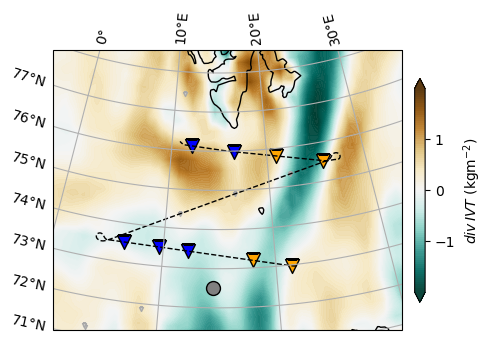

In [11]:
if do_plotting:
    import plotting_sector_sonde_locations as sonde_plotting
    sonde_plotting.main(flight,ar_of_day,ds,halo_df,Dropsondes,relevant_sondes_dict,
         internal_sondes_dict,snd_halo_icon_hmp,plot_path)

In [12]:
relevant_sector_sondes={}
relevant_sector_sondes["warm"]=relevant_warm_sector_sondes
relevant_sector_sondes["cold"]=relevant_cold_sector_sondes

## --> add relevant sondes with "cold" and "warm" key.    
inflow=False
# Load config file
config_file=data_config.load_config_file(major_work_path,"data_config_file")
cmpgn_cls=flightcampaign.HALO_AC3(is_flight_campaign=True,
                             major_path=config_file["Data_Paths"]["campaign_path"],
                             aircraft="HALO",interested_flights=flight,instruments=["radar","radiometer","sonde"])               

Moisture_CONV=Budgets.Moisture_Convergence(cmpgn_cls,flight,config_file,ar_of_day=ar_of_day,
                 grid_name="Real_Sondes",sector_types=[sector_to_plot],
                do_instantan=False,calc_from_scalar_values=scalar_based_div)                    
ICON_Moisture_CONV=Budgets.Moisture_Convergence(cmpgn_cls,flight,config_file,ar_of_day=ar_of_day,
                 grid_name="ICON_Sondes",sector_types=[sector_to_plot],do_instantan=False)

C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository//data_config_file.ini
Config-file C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository//data_config_file.ini.ini  already exists
Overall directory of campaign is:  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3


In [13]:
# for divergence calculations we have to create synthetic sondes if they are not existent in the relevant sector 
if flight[0]=="RF05" and sector_to_plot=="cold":
    synth_sonde_times=relevant_sondes_dict["cold_sector"]["out"].index
    #This is based on icon
    synth_sonde_hmc={}
    for key in halo_icon_hmc.keys():
        synth_sonde_hmc[key]=halo_icon_hmc[key].loc[synth_sonde_times]       
    
    synth_sonde_hmc["wind"]=np.sqrt(synth_sonde_hmc["u"]**2+synth_sonde_hmc["v"]**2)
    synth_sonde_hmc["transport"]=synth_sonde_hmc["wind"]*synth_sonde_hmc["q"]
    # Allocate Sondes Position all for synthetic additional sondes
    synth_sondes_pos_all=pd.DataFrame(data=np.nan,columns=["Halo_Lat","Halo_Lon"],
                            index=pd.DatetimeIndex(synth_sonde_times))
    synth_sondes_pos_all["Halo_Lat"][:]=halo_df["latitude"].loc[synth_sonde_times]
    synth_sondes_pos_all["Halo_Lon"][:]=halo_df["longitude"].loc[synth_sonde_times]

    Moisture_CONV.additional_sondes_pos_all=synth_sondes_pos_all

In [14]:
if Moisture_CONV.calc_from_scalar_values:
    Moisture_CONV.perform_entire_sonde_ac3_divergence_scalar_calcs(Dropsondes,relevant_sector_sondes,with_uncertainty=True)
else:
    # Divergence values result from vector based calculations of wind field, not scalar wspeed
    Moisture_CONV.perform_entire_sonde_ac3_divergence_vector_calcs(Dropsondes,relevant_sector_sondes,with_uncertainty=True)
Moisture_CONV.vertically_integrated_divergence()

['2022-03-16T10:46:57.000000000', '2022-03-16T10:56:15.000000000', '2022-03-16T11:03:35.000000000', '2022-03-16T11:14:00.000000000', '2022-03-16T11:21:25.000000000', '2022-03-16T11:28:35.000000000', '2022-03-16T11:39:17.000000000', '2022-03-16T11:51:59.000000000', '2022-03-16T12:13:00.000000000', '2022-03-16T12:21:11.000000000', '2022-03-16T12:35:11.000000000', '2022-03-16T12:41:23.000000000', '2022-03-16T12:48:51.000000000', '2022-03-16T13:11:55.000000000', '2022-03-16T13:22:31.000000000', '2022-03-16T13:33:13.000000000', '2022-03-16T13:48:06.000000000', '2022-03-16T13:58:21.000000000', '2022-03-16T14:07:17.000000000', '2022-03-16T14:16:19.000000000', '2022-03-16T14:27:28.000000000', '2022-03-16T14:46:46.000000000', '2022-03-16T17:22:12.000000000']
domain ready for regression
Perform divergence via regression method: least-squared


C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

Perform divergence via regression method: least-squared


C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

Perform divergence via regression method: least-squared


C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

Perform divergence via regression method: least-squared


C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

Perform divergence via regression method: least-squared


C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

AR_entire_2
moisture advection saved as:  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3/data/budgets/RF06_AR_entire_2_warm_Real_Sondes_vector_adv_q.csv
vector mass convergence saved as:  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3/data/budgets/RF06_AR_entire_2_warm_Real_Sondes_vector_mass_convergence.csv


C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid 

In [15]:
if sector_to_plot=="warm": relevant_sondes=relevant_sector_sondes["warm"]
else: relevant_sondes=relevant_sector_sondes["cold"]
sonde_sector_times=sonde_times_series.iloc[relevant_sondes].index
if flight[0]=="RF05" and sector_to_plot=="cold":
    sonde_sector_times=sonde_sector_times.append(relevant_sondes_dict["cold_sector"]["out"].index)

## Radiometer dataset

In [16]:
# processing_path packages
import data_config
import measurement_instruments_ql
import campaign_netcdf
import halodataplot as Data_Plotter
import quicklook_dicts
radar_dict={}
bahamas_dict={}  
campaign=cmpgn_cls.name
airborne_data_importer_path=major_work_path+\
                                "hamp_processing_py/"+\
                                    "hamp_processing_python/Flight_Data/"+campaign+"/"
date=flight_dates[flight[0]]
###############################################################################
inflow=False
# Radar reflectivity
cfg_dict=quicklook_dicts.get_prcs_cfg_dict(flight,date,campaign,cmpgn_cls.campaign_path)
cfg_dict["device_data_path"]=airborne_data_importer_path
with HiddenPrints():
    # Data Handling 
    datasets_dict, data_reader_dict=quicklook_dicts.get_data_handling_attr_dicts()
    # Get Plotting Handling
    plot_handler_dict, plot_cls_args_dict,plot_fct_args_dict=\
                            quicklook_dicts.get_plotting_handling_attrs_dict()

HALO_Devices_cls=measurement_instruments_ql.HALO_Devices(cfg_dict)
HALO_Devices_cls.update_major_data_path(cmpgn_cls.campaign_path)
Bahamas_cls=measurement_instruments_ql.BAHAMAS(HALO_Devices_cls)
Radar_cls=measurement_instruments_ql.RADAR(HALO_Devices_cls)
Radiometer_cls=measurement_instruments_ql.HAMP(HALO_Devices_cls)
import halodataplot as halo_data_plotter
    
Quick_Plotter=Data_Plotter.Quicklook_Plotter(cfg_dict)
Radiometer_Quicklook=halo_data_plotter.Radiometer_Quicklook(cfg_dict)
calibrated_hamp=False
Radiometer_cls.open_processed_hamp_data(open_calibrated=calibrated_hamp,
                            newest_version=True)
if not calibrated_hamp:
    mwr=Radiometer_cls.processed_hamp_ds
else:
    mwr=Radiometer_cls.calib_processed_hamp_ds
if pd.Timestamp(inflow_times[0])<pd.Timestamp(outflow_times[-1]):
    mwr_cutted=mwr.sel({"time":slice(inflow_times[0],outflow_times[-1])})
else:
    mwr_cutted=mwr.sel({"time":slice(outflow_times[0],inflow_times[-1])})
Radiometer_Quicklook.radiometer_tb_dict=mwr_cutted
Radiometer_Quicklook.cfg_dict["Flight_Dates_used"]
#Radiometer_Quicklook.plot_radiometer_TBs(flight[0],raw_measurements=False)

Typhon module cannot be loaded
C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository/hamp_processing_py/hamp_processing_python/Flight_Data/HALO_AC3/all_nc/HALO_HALO_AC3_radiometer_unified_*20220316_v0*.nc


{'20220316': ['RF06']}

## Apply Q Regression Retrieval

In [17]:
# Predefinitions
import matplotlib.pyplot as plt
import retrieval
import PAMTRA_sim_analysis

# Predefinitions
coeff_path="C:\\Users\\u300737\\Desktop\\Desktop_alter_Rechner\\PhD_UHH_WIMI\\Work\\GIT_Repository"+\
            "\\hamp_processing_py\\hamp_processing_python\\Flight_Data\\HALO_AC3\\retrieval\\"
var_to_retrieve="q"
order=2
# get MWR heights to choose relevant retrieval coefficients
halo_height=pd.Series(data=mwr["alt"].values,index=pd.DatetimeIndex(mwr["alt"].time[:]))

In [18]:
# # get all relevant retrieval heights
import glob
retrieval_coeff_files=glob.glob(coeff_path+var_to_retrieve+"*")
retrieval_coeff_heights=[int(file.split("_")[-1][:-4]) for file in retrieval_coeff_files]

In [19]:
# Process brightness temperatures
brightness_Ts=pd.DataFrame(data=np.array(mwr["TB"][:]),
                           index=pd.DatetimeIndex(np.array(mwr.time[:])),
                           columns=np.array(mwr.freq[:]))
brightness_Ts=brightness_Ts.sort_index(axis=1)
# The retrieved hamp Q profiles for divergence calculations will rely on smoothened TBs
smoothed_brightness_Ts=brightness_Ts.rolling("10s",min_periods=8).mean()
# Initialize Retrieval class, most attributes are unused
regr_retrieval=retrieval.Regression_Retrieval
Smoothed_Q_Retrieval=regr_retrieval(xr.Dataset(),"q",smoothed_brightness_Ts,order,[date],os.getcwd(),
                      added_noise=True)
Smoothed_Q_Retrieval.y=smoothed_brightness_Ts
Smoothed_Q_Retrieval.build_K_reg()
TB_K_reg_smoothed=Smoothed_Q_Retrieval.K_reg

Retrieved var saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository\hamp_processing_py\hamp_processing_python\Flight_Data\HALO_AC3\retrieval\RF06_retrieved_q.csv
Retrieved Variable saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository\hamp_processing_py\hamp_processing_python\Flight_Data\HALO_AC3\retrieval\RF06_retrieved_q.csv
Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/RF06_AR_entire_2_warmQuicklook_retrieval_hamp_sondes.png


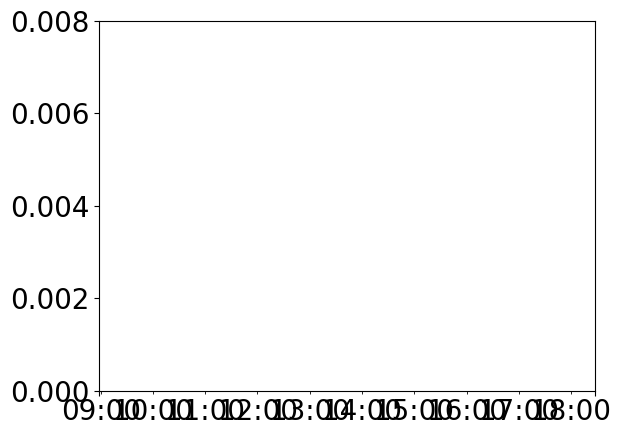

In [20]:
#------------------------------------------------------------------------------------------------------------#
# Retrieval
def retrieve_met_var(var_to_retrieve,TB_K_reg_smoothed,halo_height,
                    retrieval_coeff_path="C:\\Users\\u300737\\Desktop\\Desktop_alter_Rechner\\"+\
                        "PhD_UHH_WIMI\\Work\\GIT_Repository\\hamp_processing_py\\hamp_processing_python\\"+\
                        "Flight_Data\\HALO_AC3\\retrieval\\"):
    
    import glob
    retrieval_coeff_files=glob.glob(coeff_path+var_to_retrieve+"*")
    retrieval_coeff_heights=[int(file.split("_")[-1][:-4]) for file in retrieval_coeff_files]
    
    t_range=TB_K_reg_smoothed.shape[0]
    for t in range(t_range):#:
        rel_TB_K_reg=TB_K_reg_smoothed[t,:]
        act_halo_height=halo_height.iloc[t]
        # add height depedent retrieval applier
        m_est_heights=open_height_relevant_retrieval(retrieval_coeff_heights,var_to_retrieve,act_halo_height,
                                   coeff_path=retrieval_coeff_path)
        if t==0:
            var_retrieved=pd.DataFrame(data=np.nan, columns=m_est_heights.index,index=brightness_Ts.index)

        if not (flight[0]=="RF06" and ar_of_day=="AR_entire_1"):
            for z in range(m_est_heights.shape[0]):
                var_retrieved.iloc[t,z]=m_est_heights.iloc[z,:].dot(Smoothed_Q_Retrieval.K_reg[t,:].T)
        performance.updt(t_range,t)
    if var_to_retrieve=="log_q":
        var_retrieved=np.exp(var_retrieved)
    return var_retrieved
#------------------------------------------------------------------------------------------------------------#
retrieval_coeff_path="C:\\Users\\u300737\\Desktop\\Desktop_alter_Rechner\\"+\
                                   "PhD_UHH_WIMI\\Work\\GIT_Repository\\hamp_processing_py\\hamp_processing_python\\"+\
                                   "Flight_Data\\HALO_AC3\\retrieval\\"
# Sonde retrieval
retrieved_var_file_name=retrieval_coeff_path+flight[0]+"_retrieved_"+var_to_retrieve+".csv"

recalculate_anyhow=False
# check if file already exists
if os.path.exists(retrieved_var_file_name):
    if not recalculate_anyhow:
        var_retrieved=pd.read_csv(retrieved_var_file_name,index_col=0)
        var_retrieved.index=pd.DatetimeIndex(var_retrieved.index)
        var_retrieved.columns=var_retrieved.columns.astype(float)
        #var_retrieved.to_csv(retrieved_var_file_name)
        print("Retrieved var saved as:",retrieved_var_file_name)
    else:
        var_retrieved=retrieve_met_var(var_to_retrieve,TB_K_reg_smoothed,halo_height)
        retrieved_var_file_name=retrieval_coeff_path+flight[0]+"_retrieved_"+var_to_retrieve+".csv"

else:
    var_retrieved=retrieve_met_var(var_to_retrieve,TB_K_reg_smoothed,halo_height)       
    var_retrieved.to_csv(retrieved_var_file_name)
    print("Retrieved var saved as:",retrieved_var_file_name)
    
print("Retrieved Variable saved as:",retrieved_var_file_name)
var_retrieved_at_sonde=var_retrieved.loc[sonde_sector_times]
var_retrieved.max(axis=1).plot()
plt.ylim([0,0.008])
for sonde in var_retrieved_at_sonde.index:
    var_retrieved_at_sonde[var_retrieved_at_sonde<0.0]=0.0
plot_path=start_path+"/../plots/"
fig_name=flight[0]+"_"+ar_of_day+"_"+sector_to_plot+"Quicklook_retrieval_hamp_sondes.png"
plt.savefig(plot_path+fig_name)
print("Figure saved as:",plot_path+fig_name)

In [21]:
plot_q_retrieval(flight,ar_of_day,var_to_retrieve,var_retrieved)

This sector overpasses sea-ice where the retrieval is not yet performing correctly.


### ICON Sonde values

In [22]:
sonde_icon_hmc={}
for key in halo_icon_hmc.keys():
    sonde_icon_hmc[key]=halo_icon_hmc[key].loc[sonde_sector_times]       

sonde_icon_hmc["wind"]=np.sqrt(sonde_icon_hmc["u"]**2+sonde_icon_hmc["v"]**2)
sonde_icon_hmc["transport"]=sonde_icon_hmc["wind"]*sonde_icon_hmc["q"]
# Allocate Sondes Position all for ICON Moisture CONV, no rerun is needed
ICON_Moisture_CONV.sondes_pos_all=Moisture_CONV.sondes_pos_all.copy()
#####-----------------------------------------------------####
if flight[0]=="RF05" and sector_to_plot=="cold":
    new_sondes_pos_all=ICON_Moisture_CONV.sondes_pos_all.copy()
    del new_sondes_pos_all[sector_to_plot]["dx"]
    del new_sondes_pos_all[sector_to_plot]["dy"]
    sector_sonde_values={}
    sector_relevant_times={}
    
    new_sondes_pos_all[sector_to_plot]=new_sondes_pos_all[sector_to_plot].append(Moisture_CONV.additional_sondes_pos_all)
    # Positions relevant for divergence calculations
    ICON_Moisture_CONV.sondes_pos_all[sector_to_plot]=ICON_Moisture_CONV.get_xy_coords_for_domain(
               new_sondes_pos_all[sector_to_plot])

sector_div_vars={}
uninterp_vars={}
interp_vars={}
# Run divergence calculations via regression for transport, q and wind

sector_icon_mean_qv,sector_icon_dx_qv,sector_icon_dy_qv=\
        ICON_Moisture_CONV.run_haloac3_icon_sonde_regression(
                            ICON_Moisture_CONV.sondes_pos_all[sector_to_plot],
                            sonde_icon_hmc,"transport")

sector_icon_mean_q,sector_icon_dx_q_calc,sector_icon_dy_q_calc=\
    ICON_Moisture_CONV.run_haloac3_icon_sonde_regression(
                            ICON_Moisture_CONV.sondes_pos_all[sector_to_plot],
                            sonde_icon_hmc,"q")

sector_icon_mean_scalar_wind,sector_icon_dx_scalar_wind,sector_icon_dy_scalar_wind=\
    ICON_Moisture_CONV.run_haloac3_icon_sonde_regression(
                            ICON_Moisture_CONV.sondes_pos_all[sector_to_plot],
                                                sonde_icon_hmc,
                                                "wind")
##############################################################
# Post calculations
sector_icon_div_qv=(sector_icon_dx_qv+sector_icon_dy_qv)*1000
sector_icon_div_scalar_wind = (sector_icon_dx_scalar_wind+sector_icon_dy_scalar_wind)
sector_icon_div_q_calc      = (sector_icon_dx_q_calc+sector_icon_dy_q_calc)
intersect_icon_index=sector_icon_div_qv.index.intersection(sector_icon_div_scalar_wind.index)
intersect_icon_index=intersect_icon_index.intersection(sector_icon_div_q_calc.index)

sector_icon_div_scalar_mass=sector_icon_div_scalar_wind*\
                sonde_icon_hmc["q"].iloc[:,1:].mean(axis=0).values*1000
sector_icon_adv_q_calc=sector_icon_div_q_calc*\
            sonde_icon_hmc["wind"].iloc[:,1:].mean(axis=0).values*1000

z_height=sonde_icon_hmc["Z_Height"].iloc[:,:].mean(axis=0)
sector_icon_div_scalar_mass.index=z_height[1:]
sector_icon_adv_q_calc.index=z_height[1:]
ICON_Moisture_CONV.div_scalar_mass={}
ICON_Moisture_CONV.adv_q_calc={}
ICON_Moisture_CONV.div_scalar_mass[sector_to_plot] = sector_icon_div_scalar_mass
ICON_Moisture_CONV.adv_q_calc[sector_to_plot]      = sector_icon_adv_q_calc

### Retrieval Sondes HMC 

In [28]:
import scipy.interpolate as scint
# create retrieval divergence calculations with new Moisture Budget class
# it includes the retrieved q and then, from the sondes, p, u, v and calculates transport.
# check for corresponding index of sondes and retrieval
# each sonde has another height. Does it still work?
Retrieval_Moisture_CONV=Budgets.Moisture_Convergence(cmpgn_cls,flight,config_file,
                 grid_name="Retrieval_Sondes",sector_types=[sector_to_plot],do_instantan=False)
correct_sector=True
if flight[0]=="RF06":
    correct_sector=False
if correct_sector:        
    sonde_retrieval_hmc={}
    unified_heights=var_retrieved_at_sonde.columns
    for key in halo_icon_hmc.keys():
        if key=="IVT":
            continue
        if key=="q":
            sonde_retrieval_hmc[key]=var_retrieved_at_sonde
        else:
            sonde_retrieval_hmc[key]=halo_icon_hmc[key].loc[sonde_sector_times]
        
            var_df=pd.DataFrame(data=np.nan,columns=unified_heights,index=sonde_sector_times)
            for sonde in sonde_sector_times:
                profile=halo_icon_hmc[key].loc[sonde,:].values
                height_levels=halo_icon_hmc["Z_Height"].loc[sonde_sector_times].mean(axis=0).values
                var_series=pd.Series(data=profile,
                            index=height_levels)
                ## Interpolation function
                var_fct = scint.interp1d(var_series.index, var_series,fill_value="extrapolate")
                ## Get interpolated data
                var_series_interp=pd.Series(var_fct(unified_heights),
                                    index=unified_heights)
                var_df.loc[sonde]=var_series_interp
            sonde_retrieval_hmc[key]=var_df#return var_series_interp
            print(key," Sonde retrieval hmc shape:",sonde_retrieval_hmc[key].shape)

    sonde_retrieval_hmc["wind"]=np.sqrt(sonde_retrieval_hmc["u"]**2+sonde_retrieval_hmc["v"]**2)
    sonde_retrieval_hmc["transport"]=sonde_retrieval_hmc["wind"]*sonde_retrieval_hmc["q"]
else:
    print("No Retrieval at sonde locations considered, as not applicable to HAMP data")

No Retrieval at sonde locations considered, as not applicable to HAMP data


In [29]:
if correct_sector:
    # Allocate Sondes Position all for ICON Moisture CONV, no rerun is needed
    Retrieval_Moisture_CONV.sondes_pos_all=Moisture_CONV.sondes_pos_all
    sector_div_vars={}
    uninterp_vars={}
    interp_vars={}
    # Run divergence calculations via regression for transport, q and wind
    sector_retrieval_mean_qv,sector_retrieval_dx_qv,sector_retrieval_dy_qv=\
        Retrieval_Moisture_CONV.run_haloac3_icon_sonde_regression(
                            Retrieval_Moisture_CONV.sondes_pos_all[sector_to_plot],
                            sonde_retrieval_hmc,"transport")

    sector_retrieval_mean_q,sector_retrieval_dx_q_calc,sector_retrieval_dy_q_calc=\
        Retrieval_Moisture_CONV.run_haloac3_icon_sonde_regression(
                            Retrieval_Moisture_CONV.sondes_pos_all[sector_to_plot],
                            sonde_retrieval_hmc,"q")
    sector_retrieval_mean_scalar_wind,sector_retrieval_dx_scalar_wind,sector_retrieval_dy_scalar_wind=\
        Retrieval_Moisture_CONV.run_haloac3_icon_sonde_regression(
                            Retrieval_Moisture_CONV.sondes_pos_all[sector_to_plot],
                                                sonde_retrieval_hmc,
                                                "wind")
    # Post calculations
    sector_retrieval_div_qv=(sector_retrieval_dx_qv+sector_retrieval_dy_qv)*1000
    sector_retrieval_div_scalar_wind = (sector_retrieval_dx_scalar_wind+sector_retrieval_dy_scalar_wind)
    sector_retrieval_div_q_calc      = (sector_retrieval_dx_q_calc+sector_retrieval_dy_q_calc)
    
    intersect_retrieval_index=sector_retrieval_div_qv.index.intersection(sector_retrieval_div_scalar_wind.index)
    intersect_retrieval_index=intersect_retrieval_index.intersection(sector_retrieval_div_q_calc.index)
    sector_retrieval_div_scalar_mass=sector_retrieval_div_scalar_wind.loc[intersect_retrieval_index]*\
                sonde_retrieval_hmc["q"].loc[:,intersect_retrieval_index].mean(axis=0).values*1000
    sector_retrieval_adv_q_calc=sector_retrieval_div_q_calc.loc[intersect_retrieval_index]*\
            sonde_retrieval_hmc["wind"].loc[:,intersect_retrieval_index].mean(axis=0).values*1000##
    Retrieval_Moisture_CONV.div_scalar_mass={}
    Retrieval_Moisture_CONV.adv_q_calc={}
    Retrieval_Moisture_CONV.div_scalar_mass[sector_to_plot] = sector_retrieval_div_scalar_mass
    Retrieval_Moisture_CONV.adv_q_calc[sector_to_plot]      = sector_retrieval_adv_q_calc
    z_height_retrieval_all=sonde_retrieval_hmc["Z_Height"].iloc[:,:].mean(axis=0)
    z_height_retrieval=z_height_retrieval_all.loc[intersect_retrieval_index]
else:
    z_height_retrieval=np.nan


### ICON_Moisture_CONV vertically_integrated_divergence

In [25]:
integrated_divergence={}
p_grid=sonde_icon_hmc["p"].mean(axis=0)

pres_index=pd.Series(data=p_grid.values,index=z_height.values)
g=9.82


ICON_Moisture_CONV.div_scalar_mass[sector_to_plot].index = pres_index.dropna()
ICON_Moisture_CONV.adv_q_calc[sector_to_plot].index      = pres_index.dropna()

integrated_divergence[sector_to_plot]={}
integrated_divergence[sector_to_plot]["mass_div"]= 1/(997)*np.trapz(
    ICON_Moisture_CONV.div_scalar_mass[sector_to_plot].values*\
    ICON_Moisture_CONV.div_scalar_mass[sector_to_plot].index)/1000*3600
integrated_divergence[sector_to_plot]["q_ADV"]= 1/(997)*np.trapz(
    ICON_Moisture_CONV.adv_q_calc[sector_to_plot].values*\
    ICON_Moisture_CONV.adv_q_calc[sector_to_plot].index)/1000*3600

ICON_Moisture_CONV.integrated_divergence=integrated_divergence

### Retrieval Moisture CONV vertically integrated divergence

In [30]:
if correct_sector:
    retr_integrated_divergence={}
    retr_p_grid=sonde_retrieval_hmc["p"].mean(axis=0)
    retr_pres_index=pd.Series(retr_p_grid)
    
    Retrieval_Moisture_CONV.div_scalar_mass[sector_to_plot].index=retr_pres_index.dropna()
    Retrieval_Moisture_CONV.adv_q_calc[sector_to_plot].index=retr_pres_index.dropna()

    retr_integrated_divergence[sector_to_plot]={}
    retr_integrated_divergence[sector_to_plot]["mass_div"]= 1/(g*997)*np.trapz(
        Retrieval_Moisture_CONV.div_scalar_mass[sector_to_plot].values*\
        Retrieval_Moisture_CONV.div_scalar_mass[sector_to_plot].index)/1000*3600
    retr_integrated_divergence[sector_to_plot]["q_ADV"]= 1/(g*997)*np.trapz(
        Retrieval_Moisture_CONV.adv_q_calc[sector_to_plot].values*\
        Retrieval_Moisture_CONV.adv_q_calc[sector_to_plot].index)/1000*3600
    
    ###################################################################
    ### Default to use 
    #retr_integrated_divergence[sector_to_plot]={}
    #retr_integrated_divergence[sector_to_plot]["mass_div"]= 1/(997)*np.trapz(
    #    Retrieval_Moisture_CONV.div_scalar_mass[sector_to_plot].values*retr_pres_index.dropna()[::-1])/1000*3600
    #retr_integrated_divergence[sector_to_plot]["q_ADV"]=1/(997)*np.trapz(\
    #    Retrieval_Moisture_CONV.adv_q_calc[sector_to_plot].values*retr_pres_index.dropna()[::-1])/1000*3600
    ###################################################################    
    Retrieval_Moisture_CONV.integrated_divergence=retr_integrated_divergence
    #retr_integrated_divergence

Moisture_CONV.sector_sonde_values[sector_to_plot]["wind"]=\
    np.sqrt(Moisture_CONV.sector_sonde_values[sector_to_plot]["u"]**2+\
            Moisture_CONV.sector_sonde_values[sector_to_plot]["v"]**2)

Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/RF06_AR_entire_2_warm_Sondes.png


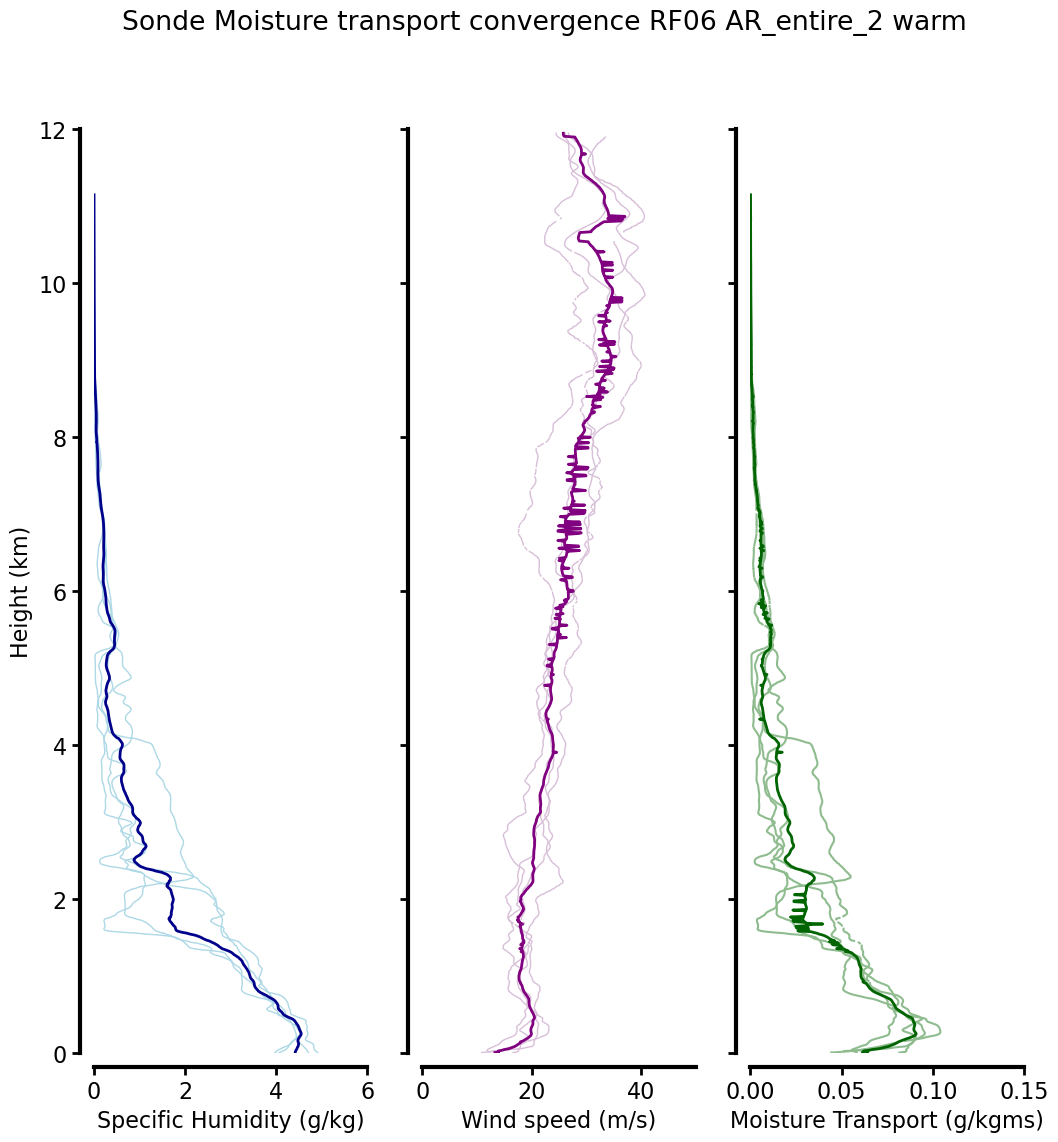

In [31]:
if do_plotting:
    plot_vertical_sonde_profiles(Moisture_CONV,plot_path)

## Sonde Divergence Calculations

Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/RF06_AR_entire_2_warm_sonde_moist_transp_divergence.png


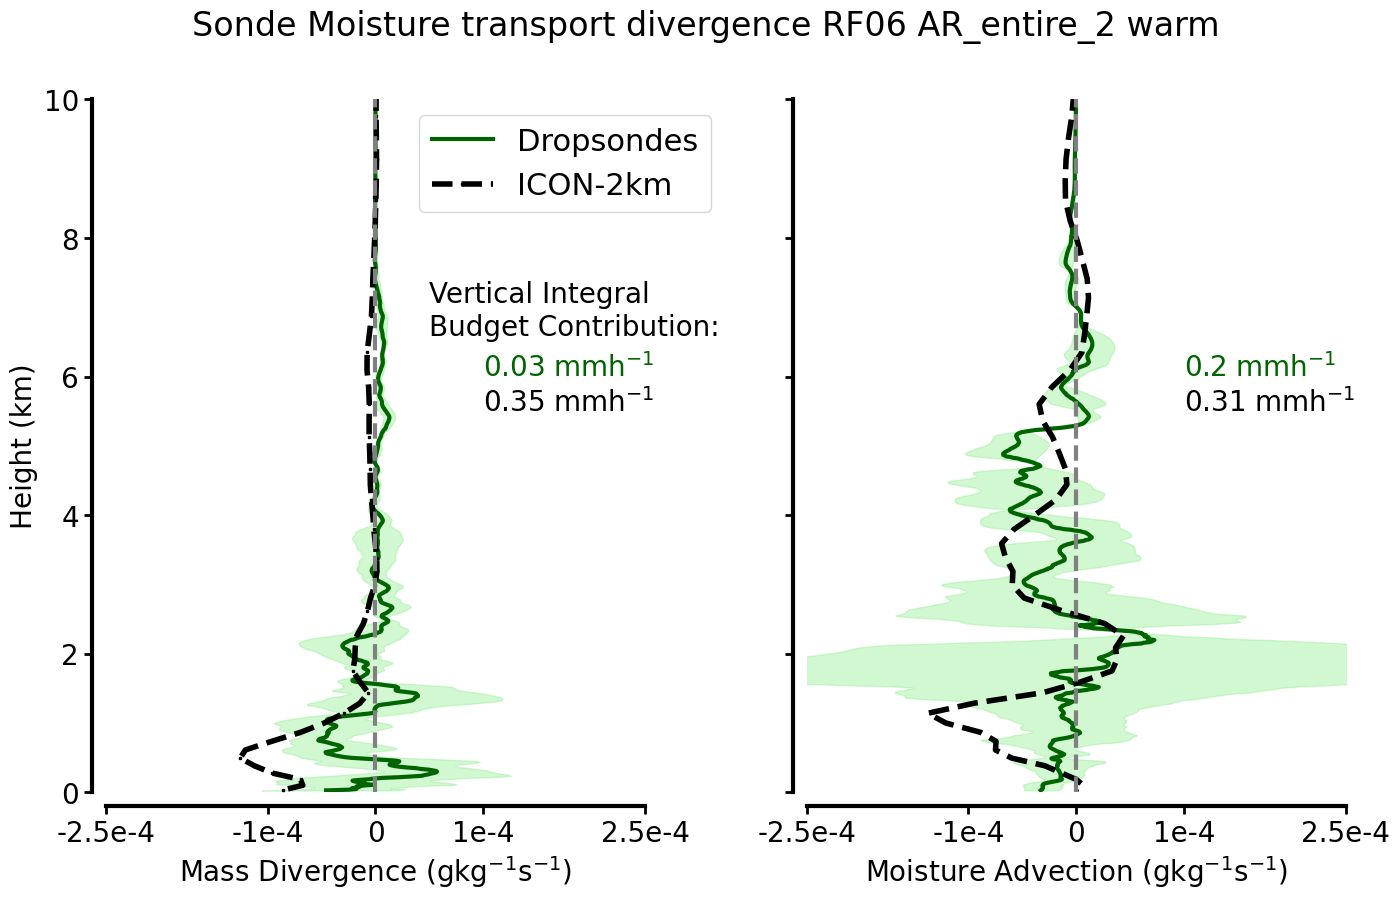

In [32]:
plot_sondes=True
if flight[0]=="RF05" and sector_to_plot=="cold":
    z_height_retrieval=pd.Series()
    plot_sondes=False
plot_haloac3_atmospheric_moist_trans_divergence(Moisture_CONV,ICON_Moisture_CONV,
                                                Retrieval_Moisture_CONV,sector_to_plot,
                                                z_height,z_height_retrieval,plot_sondes=plot_sondes,
                                               scalar_based_div=scalar_based_div)